In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd
import datetime as dt
from itertools import chain

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [47]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:////Users/kristenhanold/Desktop/sqlalchemy-challenge/Resources/hawaii.sqlite")

In [48]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [49]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [50]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [51]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [52]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [53]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set 
# chosen dates in README file were aug 1st to aug 7th and we'll be looking at the previous year 2017

start_date = '2017-08-01'
end_date = '2017-08-07'

# calling calc_temps function
trip_summary = (calc_temps(start_date, end_date))

# creating a dataframe to hold min, avg, and max temps for our trip dates 
trip_summary_df = pd.DataFrame(trip_summary, columns = ['MIN', 'AVG', 'MAX'])
trip_summary_df

,MIN,AVG,MAX
0,72.0,79.25,83.0


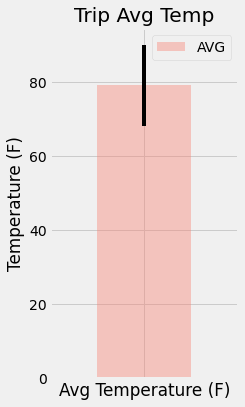

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error_bar = [trip_summary_df['MAX'] - trip_summary_df['MIN']]
trip_summary_df.plot(kind = 'bar', y = 'AVG', yerr = error_bar, color = 'salmon', figsize = (3,6), alpha = 0.4)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.xlabel('Avg Temperature (F)')
plt.tick_params(axis = 'x', labelbottom = False)
plt.show()

### Daily Rainfall Average

In [55]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_info = [station.station, station.name, func.round(func.sum(measurement.prcp), 2), station.latitude, station.longitude, station.elevation]

avg_rain_query = session.query(*station_info).filter(station.station == measurement.station).\
                    group_by(measurement.station).\
                    filter((measurement.date >= start_date) & (measurement.date <= end_date)).\
                    order_by(func.round(func.sum(measurement.prcp), 2).desc()).all()
avg_rain_query
                           
avg_rain_df = pd.DataFrame(avg_rain_query, columns = ['Station', 'Name', 'Total Amt of Rainfall', 'Latitude', 'Longitude', 'Elevation'])
avg_rain_df

,Station,Name,Total Amt of Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.36,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.22,21.52130,-157.83740,7.0
2,USC00519281,"WAIHEE 837.5, HI US",0.06,21.45167,-157.84889,32.9
3,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.27160,-157.81680,3.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5


### Daily Temperature Normals

In [66]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.round(func.avg(measurement.tobs),2), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15, 77.0)]

In [67]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
range_of_dates = pd.date_range(start_date, end_date).strftime('%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings
new_range_of_dates = pd.date_range(start_date, end_date).strftime('%m-%d')

new_range_of_dates

Index(['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07'], dtype='object')

In [68]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []

# loop through our range of dates and add their min, max and avg temps calculated using the 'daily_normals' function
# to our list called 'normals'
for date in new_range_of_dates:
    normal = daily_normals(date)
    normals.append(normal)
    
print(normals)

[[(67.0, 75.54, 83.0)], [(68.0, 75.6, 84.0)], [(70.0, 76.61, 85.0)], [(69.0, 76.71, 84.0)], [(69.0, 76.15, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.16, 83.0)]]


In [69]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# using chain.from_iterable to break up each index in our list 'normals' 
# so they can then be split and placed in their designated columns (min, avg, or max)
new_normals = [x for x in chain.from_iterable(normals)]
daily_normals_df = pd.DataFrame(new_normals, columns = ['MIN', 'AVG', 'MAX'], index = [new_range_of_dates])
daily_normals_df

,MIN,AVG,MAX
08-01,67.0,75.54,83.0
08-02,68.0,75.60,84.0
08-03,70.0,76.61,85.0
08-04,69.0,76.71,84.0
08-05,69.0,76.15,82.0
08-06,67.0,76.25,83.0
08-07,71.0,77.16,83.0


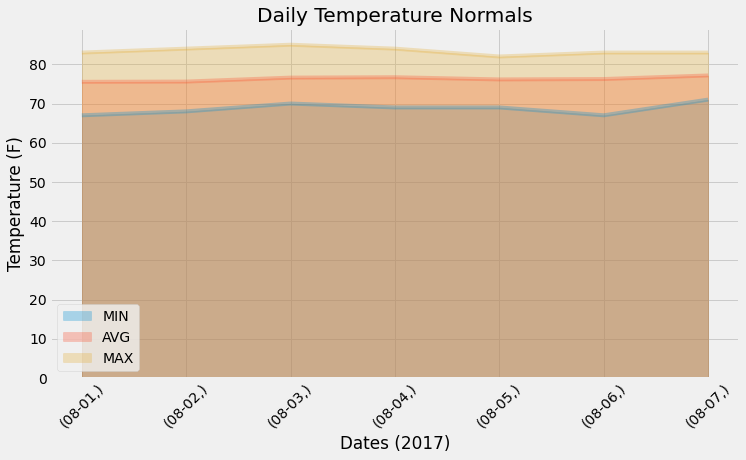

In [87]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind = 'area', stacked = False, figsize = (11, 6), alpha = 0.3)
plt.title('Daily Temperature Normals')
plt.ylabel('Temperature (F)')
plt.xlabel('Dates (2017)')
plt.xticks(rotation = 45)
plt.show()

## Close Session

In [88]:
session.close()